In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import ehr_ml.timeline
import ehr_ml.ontology
import ehr_ml.index
import ehr_ml.labeler
import ehr_ml.clmbr
from ehr_ml.clmbr import Trainer
from ehr_ml.clmbr import PatientTimelineDataset
from ehr_ml.clmbr.dataset import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')


<Figure size 432x288 with 0 Axes>

In [45]:
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr'
results_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/notebooks/figures'
extract_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/extracts/20210723'
cohort_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/cohort'
hparams_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/hyperparams'

data_path = f'/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/data/labelled_data/hospital_mortality/pretrained/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01'

bl_model_path = f'{model_path}/pretrained/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01'
cl_model_path = f'{model_path}/contrastive_learn/model/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/'

In [46]:
train_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_train.csv')
val_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_val.csv')
test_pids = pd.read_csv(f'{data_path}/ehr_ml_patient_ids_test.csv')

train_days = pd.read_csv(f'{data_path}/day_indices_train.csv')
val_days = pd.read_csv(f'{data_path}/day_indices_val.csv')
test_days = pd.read_csv(f'{data_path}/day_indices_test.csv')

train_labels = pd.read_csv(f'{data_path}/labels_train.csv')
val_labels = pd.read_csv(f'{data_path}/labels_val.csv')
test_labels = pd.read_csv(f'{data_path}/labels_test.csv')

train_data = (train_labels.to_numpy().flatten(),train_pids.to_numpy().flatten(),train_days.to_numpy().flatten())
val_data = (val_labels.to_numpy().flatten(),val_pids.to_numpy().flatten(),val_days.to_numpy().flatten())
test_data = (test_labels.to_numpy().flatten(),test_pids.to_numpy().flatten(),test_days.to_numpy().flatten())

dataset = PatientTimelineDataset( f'{extract_path}/extract.db', f'{extract_path}/ontology.db', f'{bl_model_path}/info.json', train_data, test_data )

In [50]:
cl_grid = list(
    ParameterGrid(
        yaml.load(
            open(
                f"{os.path.join('/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/best','hyperparams')}.yml",
                'r'
            ),
            Loader=yaml.FullLoader
        )
    )
)

In [ ]:
cos_sims = []
cos_sim = nn.CosineSimilarity(dim=-1)
with torch.no_grad():
    with DataLoader(dataset, 9262, is_val=True, batch_size=2000, seed=44, device='cuda:0') as eval_loader:
        for batch in eval_loader:
            bl_model = ehr_ml.clmbr.CLMBR.from_pretrained(bl_model_path, 'cuda:0')
            bl_outputs = bl_model(batch)['rnn']
            for cl_hp in cl_grid:
                sim = []
                for i in range(20):
                    cl_model_path = f"{model_path}/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_{cl_hp['batch_size']}_lr_{cl_hp['lr']}_temp_{cl_hp['temp']}_pool_{cl_hp['pool']}/{i}"
                    cl_model = ehr_ml.clmbr.CLMBR.from_pretrained(cl_model_path, 'cuda:0')
                    cl_outputs = cl_model(batch)['rnn']
                    sims = cos_sim(bl_outputs, cl_outputs)
                    sims = torch.mean(sims, 1)
                    sim.append(torch.mean(sims, 0).item())
                print(sim)
            cos_sims.append(sim)
print(cos_sims)


In [60]:
np_sims = np.array(cos_sims)
print(np.mean(np_sims,0))
mean_sims = np.mean(np_sims,0)

[0.57643871 0.4965348  0.45252702 0.42090608 0.39593026 0.37223704
 0.35183617 0.33317533 0.31945741 0.30877209 0.30082418 0.29177137
 0.28780901 0.28943078 0.29245434 0.30057417 0.29717783 0.30231637
 0.31525766 0.31254155]


[]


In [59]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

<Figure size 432x288 with 0 Axes>

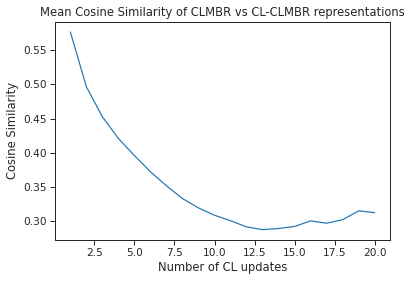

In [63]:
plt.plot([i+1 for i in range(20)],mean_sims)
plt.title('Mean Cosine Similarity of CLMBR and CL-CLMBR representations')
plt.xlabel('Number of CL updates')
plt.ylabel('Cosine Similarity')
plt.show()